In [1]:
import pandas as pd
import numpy as np

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# подгружаем датафреймы с двух листов
df_parsing = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Parsing')
df_company = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Company')

In [64]:
# создаем функцию удаления лишних символов из строк
def del_syms(text):
    # работаем только если тип строка
    if type(text) is str:
        result = ''
        syms = ['_', '-', '~', '\\', '/']
        for i in text:
            if i not in syms:
                result += i
        return result
    else:
        return text

In [83]:
# ко всем колонкам применяем функцию удаления лишних символов
for col in df_parsing.columns:
    df_parsing[col] = df_parsing[col].apply(del_syms)

In [78]:
# удалим дубликаты
df_parsing = df_parsing.drop_duplicates()
df_company = df_company.drop_duplicates()
display(df_parsing.shape)
display(df_company.shape)


(75, 5)

(75, 5)

In [101]:
# соединяем две таблицы (по 3 признакам, они одинаковы)
merged = df_parsing.join(
    df_company.set_index(['item_id', 'brand', 'Category']),
    on=['producer_id', 'brand', 'Category'],
    # rsuffix='_right',
    how='left',
)

,brand,Category,producer_id,producer_color,price,color_id,current price
0,Valentino,Shoes,aaaaa111111,black,167,black,247
1,Valentino,Shoes,aaaaa111112,black,188,black,161
2,Valentino,Shoes,aaaaa111113,black,184,black,234
3,Valentino,Shoes,aaaaa111114,black,196,black,167
4,Valentino,Shoes,aaaaa111115,black,250,black,153
...,...,...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,164,red,165
71,Stone Island,Bags,sssss111132,red,158,red,196
72,Stone Island,Bags,sssss111133,red,194,red,236
73,Stone Island,Bags,sssss111134,red,256,red,222


In [124]:
# создаем новый признак - разница цен в процентах
merged['price_diff'] = round((((merged['price'] - merged['current price']) / merged['price'])) * 100, 2)

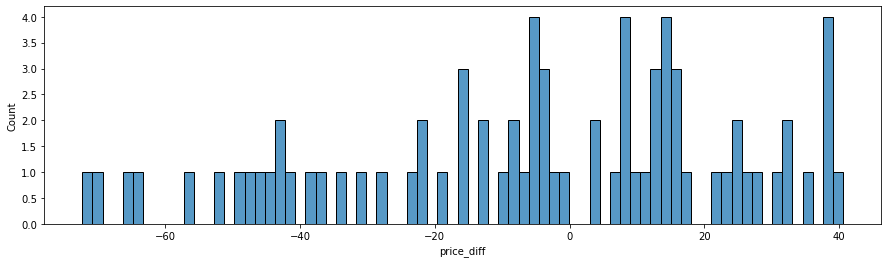

In [139]:
# смотрим на гистограме распределение разброса разности цен
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
histplot = sns.histplot(
    data=merged,
    x='price_diff',
    ax=axes,
    bins=75
)

In [173]:
# создаем признак объединяющий бренд и категорию
merged['bc'] = merged['brand'] + merged['Category']

In [194]:
# для групп бренд и категория находим квартили
qu25 = merged.groupby('bc')['price_diff'].quantile(0.25)
qu75 = merged.groupby('bc')['price_diff'].quantile(0.75)
qu25 = pd.DataFrame(qu25).reset_index().rename(columns={'price_diff':'qua25'})
qu75 = pd.DataFrame(qu75).reset_index().rename(columns={'price_diff':'qua75'})

In [196]:
# к исходной таблице присоединяем данные из нового датафрейма
# 25 квартиль
df = merged.merge(
    qu25,
    how='left'
)
# и 75 квартиль
df = df.merge(
    qu75,
    how='left'
)

,brand,Category,producer_id,producer_color,price,color_id,current price,price_diff,bc,qua25,qua75
0,Valentino,Shoes,aaaaa111111,black,167,black,247,-47.90,ValentinoShoes,-42.13,14.69
1,Valentino,Shoes,aaaaa111112,black,188,black,161,14.36,ValentinoShoes,-42.13,14.69
2,Valentino,Shoes,aaaaa111113,black,184,black,234,-27.17,ValentinoShoes,-42.13,14.69
3,Valentino,Shoes,aaaaa111114,black,196,black,167,14.80,ValentinoShoes,-42.13,14.69
4,Valentino,Shoes,aaaaa111115,black,250,black,153,38.80,ValentinoShoes,-42.13,14.69


In [197]:
# добавляем столбец с расчитанным iqr
df['iqr'] = df['qua75'] - df['qua25']

In [199]:
# добавляем столбцы с рассчитанными нижней и верхней границами
df['l_bord'] = df['qua25'] - df['iqr'] * 1.5
df['u_bord'] = df['qua75'] + df['iqr'] * 1.5

In [211]:
# добавляем признак - выброс ли строка или нет (булевая)
df['is_dev'] = (df['price_diff'] > df['l_bord']) & (df['price_diff'] < df['u_bord'])

In [214]:
# если истина тогда - не выброс
df['is_dev'] = df['is_dev'].apply(lambda x: 'no' if x else 'yes')

In [217]:
# оставляем только не выбросы
df = df[df['is_dev'] == 'no']

In [218]:
# было 75 строк, осталось 70. 5 выбросов по методу тьюки
df.shape

(70, 15)

In [223]:
# удаляем ненужные (побочные колонки)
cols_to_drop = ['bc', 'qua25', 'qua75', 'iqr', 'l_bord', 'u_bord', 'is_dev']
df = df.drop(cols_to_drop, axis=1)

In [228]:
# сбрасываем индексы и удаляем колонку со старым индексом
df = df.reset_index()
df = df.drop('index', axis=1)

In [230]:
# сохраняем в эксель
df.to_excel('data/Data_TSUM_mod.xlsx')